### Libraries 

In [1]:
import os
import operator
import json
import getpass
import nest_asyncio
from typing import Literal
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
# from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_chroma import Chroma
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool 
from langgraph.graph import StateGraph, END ,START
from langchain_experimental.utilities import PythonREPL
from unstructured.cleaners.core import clean_extra_whitespace
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage,SystemMessage,AnyMessage,AIMessage
from langchain_community.document_loaders import UnstructuredExcelLoader
from llama_index.core import SimpleDirectoryReader
from llama_cloud_services import LlamaParse

from langgraph.types import Command
from langgraph.graph import MessagesState
from langgraph.prebuilt import create_react_agent

### Environment Setup

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

nest_asyncio.apply()
load_dotenv()

# Set API keys
_set_env("LANGSMITH_API_KEY")
_set_env("OPENAI_API_KEY")
_set_env('UNSTRUCTURED_API_KEY')
_set_env('LLAMA_CLOUD_API_KEY')
_set_env('TAVILY_API_KEY')

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "InSAgent"

memory = MemorySaver()

#### Survey Load

In [3]:
file_path_survey = "/Users/omarelkhashab/PycharmProjects/InSAgent/data/consumersurvey"

survey_docs = []

loaders = [UnstructuredExcelLoader(os.path.join(file_path_survey, folder), post_processors=[clean_extra_whitespace])
           for folder in os.listdir(file_path_survey)
           if folder.endswith(".xlsx")]

for loader in loaders:
    survey_docs.extend(loader.load())

### PDF Load Llama index

In [4]:
# set up parser
parser = LlamaParse(
    result_type="markdown"  # "markdown" and "text" are available
)
file_path_pdf = "/Users/omarelkhashab/PycharmProjects/InSAgent/data/conocophillips"

pdf_docs = []
# use SimpleDirectoryReader to parse our file
file_extractor_pdf = {".pdf": parser}
loaders_pdf = [SimpleDirectoryReader(input_files=[os.path.join(file_path_pdf, folder)], file_extractor=file_extractor_pdf) 
             for folder in os.listdir(file_path_pdf)
             if folder.endswith(".pdf")]
for loader in loaders_pdf:
    pdf_docs.append(loader.load_data())

Started parsing the file under job_id 23e492e8-a878-4323-b96b-187803453f34


### Metadata filter

In [5]:
# Clean up metadata (optional)
langchain_pdf_docs = []
for doc_list in pdf_docs:  # Iterate directly over the outer list
    for doc in doc_list:   # Iterate directly over the inner list
        # Update metadata and create the new Document in one step
        updated_metadata = {"source": doc.metadata["file_name"].split(".")[0]}
        updated_content = " ".join(doc.text.split()) 
        langchain_pdf_docs.append(
            Document(page_content=updated_content, metadata=updated_metadata)
        )

for docs in survey_docs:
    source = os.path.basename(docs.metadata.get('source', '')).split(".")[0]
    docs.metadata['source'] = source
    docs.page_content = " ".join(docs.page_content.split()) 


### Splitting Docs

In [6]:
text_split = RecursiveCharacterTextSplitter()

In [7]:
pages_splits_survey = text_split.split_documents(survey_docs)
pages_splits_pdf = text_split.split_documents(langchain_pdf_docs)

#### Create Vector Stores

In [8]:
embedding = OpenAIEmbeddings(model='text-embedding-ada-002')
vectorstore_survey = Chroma.from_documents(documents=pages_splits_survey,
                                     embedding = embedding,
                                     persist_directory = "Survey_store"
                                     )
vectorstore_PDF = Chroma.from_documents(documents=pages_splits_pdf,
                                     embedding = embedding,
                                     persist_directory = "PDF_store"
                                     )

In [9]:
# vectorstore_Survey = Chroma(persist_directory = "Survey_store", 
#                      embedding_function = OpenAIEmbeddings(model='text-embedding-ada-002'))
# vectorstore_PDF = Chroma(persist_directory = "PDF_store", 
#                      embedding_function = OpenAIEmbeddings(model='text-embedding-ada-002'))

In [150]:
retriever_survey = vectorstore_survey.as_retriever(search_type = 'mmr', 
                                     search_kwargs = {'k':3, 
                                                      'lambda_mult':0.3,})
retriever_pdf = vectorstore_PDF.as_retriever(search_type = 'mmr', 
                                     search_kwargs = {'k':6, 
                                                      'lambda_mult':0.3, 'filter': {'source': "2024-conocophillips-proxy-statement"}})

In [11]:
web_search_tool = TavilySearchResults(max_results=3)

In [12]:
def format_docs(context):
    return "\n\n".join([d.page_content for d in context])

### Chat Models 

In [216]:
model = ChatOpenAI(model_name = "gpt-4o-mini", seed = 365, max_tokens = 300)
# agent_models= ChatOpenAI(model_name = 'gpt-4o-mini', seed = 365,max_tokens = 500)
# llm = ChatOllama(
#     model="mistral:latest",
#     temperature=0,
#     other params...
# )

### Prompt Template 

In [291]:
router_temp = """You are an expert at directing users' question to multiple sources.

Review the user question:

{question}

Route to the available data sources include:

1- PDF_store containing ConocoPhillips proxy statement PDF.
2- Survey_store containing surveys about Sustainability survey impacts on consumer purchases and a Christmas purchases survey.
3- websearch tool using TavilySearch.

Use PDF_store for questions about Cocophilps proxy statements, Survey_store for questions about Environmental surveys or Christmas purchases survey and websearch for general business-related questions not covered by the other stores.

Return the JSON in a single line with no extra spacing or newlines, where source_name is either PDF_store , Survey_store or websearch with no preamble or explanation 

"""

#If None of the above conditions Return the JSON in a single line with no extra spacing or newlines, where source_name is 'chat' with no preamble or explanation.

In [292]:
template_rag = """You are an assistant for question-answering tasks. 

Use the below pieces of retrieved context to answer the question:

{context} 

Think carefully about the above context.

Now, review the user question:

{question}

Provide an answer to this questions using only the above context or say it's beyond my knowledge. 

Use 7 lines maximum and keep the answer concise.

Answer:"""

In [293]:
# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return the JSON in a single line with no extra spacing or newlines, where binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question with no preamble or explanation."""


In [294]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 

Return a valid JSON object with two keys: "binary_score" set to "yes" or "no" based on whether the STUDENT ANSWER is grounded in the FACTS, and "explanation" providing reasoning. the response must always properly formatted JSON with no additional text before or after."""


In [295]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) The STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 

The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.

A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
# answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 
# 
# Return the JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

answer_grader_prompt = """ QUESTION: {question} \n\n STUDENT ANSWER: {generation} \n\n Evaluate the STUDENT ANSWER.

 Return a valid JSON object with two keys: "binary_score" set to "yes" or "no" based on whether the STUDENT ANSWER meets the criteria, and 'explanation' providing reasoning. the response must always properly formatted JSON with no additional text before or after.
 """

In [296]:
# Query Re-Writing Prompt
query_rewriting = """ You are a rephrase expert that takes the user below question:

{question} 

You are responsible to rephrase the user question in a good way that can retrieve better documents to get a better generation and answer.

"""

In [297]:
analysis_prompt = """You are an business analytics expert for making business tasks. 

you will be given a generation use only it to provide business insights or say it's hard to give a business analysis on that context

Use 4 lines maximum and keep the answer concise.

Answer:"""

In [298]:
planning_prompt = """You are an business planning expert for making business recommendations and plans. 

You will be given an business analysis: 

{generation} 

Review the above business analysis, Provide an business plans and recommendation based on it.

Use the above information or say it's hard to give a business analysis on that context. 

Use 5 lines maximum and keep the answer concise.

Answer:"""


## AgenticRAG

In [426]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    question : str
    documents : list[str]
    generation: str
    web_status: str
    router_stat : str
    max_retries: int  # Max number of retries for answer generation
    loop_step: Annotated[int, operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

In [510]:
#Nodes
def retrieve_survey(state:State):
    print("---SURVEY RETRIEVAL---")
    question = state["question"]
    documents = retriever_survey.invoke(question)
    return {'documents': documents,"router_stat":"Survey_store", "messages":[HumanMessage(content=question)]}

def retrieve_pdf(state:State):
    print("---PDF RETRIEVAL---")
    question = state["question"]
    documents = retriever_pdf.invoke(question)
    return  {'documents': documents,"router_stat":"PDF_store", "messages":[HumanMessage(content=question)]}

def web_search(state:State):
    print('"---WEB SEARCH---')
    documents = state.get("documents", [])
    question = state["question"]
    # Web search
    web_docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents,"router_stat":"websearch"}

def generate(state:State):
    print("---GENERATION---")
    question = state["question"]
    loop_step = state.get("loop_step", 0)
    
    if state["documents"] and len(state["documents"]) > 0:
            formated_doc = format_docs(state["documents"])
            rag_prompt_formated = template_rag.format(context=formated_doc, question=question)

    else:# Fallback if no documents are provided
        formated_doc = "No relevant documents found."
        rag_prompt_formated = template_rag.format(context=formated_doc, question=question)
    
    
    response = model.invoke([HumanMessage(rag_prompt_formated)])
    return {"generation": response.content, "messages": [response],"loop_step":loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    documents = state["documents"]
    question = state["question"]
    # Score each doc
    filtered_docs = []
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = model.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(str(result.content))["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
    web_status = "Yes" if not filtered_docs else "No"
    return {"documents": filtered_docs,"web_status":web_status}

def rephrase_question(state:State):
    question = state["question"]
    messages = state["messages"]
    router_stat = state["router_stat"]


    rephrase_prompt = query_rewriting.format(question=question)
    response = model.invoke([SystemMessage(rephrase_prompt)])

    new_question = response.content
    print(f"---Rephrased Question: {new_question}---")

    return {"question":new_question ,
        "messages": [response],  
        "loop_step": state["loop_step"] + 1 , "router_stat":router_stat
    }


In [428]:
#Edges functions:
def route_question(state:State):
    question = state["question"]
    route_response_prompt_formated = router_temp.format(question=question)
    route_response = model.invoke([SystemMessage(route_response_prompt_formated)])
    route_response= json.loads(route_response.content)["source_name"]
    state["router_stat"] = route_response
    # print(f"Router Status Updated: {state['router_stat']}")
    if route_response == "PDF_store":
        return state["router_stat"]
    if route_response == "Survey_store":
        return state["router_stat"]
    if route_response == "websearch":
        return state["router_stat"]


def decide_to_generate(state):
    print("---ASSESS GRADED DOCUMENTS---")

    web_status = state["web_status"]

    if web_status == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "irrelevant"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "relevant"
    
    
def grade_generation_v_documents_and_question(state):

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 2)  # Default to 5 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation
    )
    result = model.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(str(result.content))["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above

        answer_grader_prompt_formatted = answer_grader_prompt.format(
             question=question, generation=generation
        )
        result = model.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(str(result.content))["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

In [429]:
graph_builder = StateGraph(State)
graph_builder.set_conditional_entry_point(                   
    route_question, 
     {
        "PDF_store": "retrieve_pdf" ,
        "Survey_store": "retrieve_survey",
        "websearch" : "web_search",
    }
)
graph_builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "irrelevant": "web_search",
        "relevant": "generate",
    },
)

graph_builder.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "rephrase_question",
        "max retries": END,
    },
)

graph_builder.add_conditional_edges(
    "rephrase_question",
    lambda state: state["router_stat"],
    {
        "PDF_store": "retrieve_pdf" ,
        "Survey_store": "retrieve_survey",
    },
)

In [430]:
graph_builder.add_node("retrieve_pdf", retrieve_pdf)
graph_builder.add_node("retrieve_survey", retrieve_survey)
graph_builder.add_node("grade_documents", grade_documents)
graph_builder.add_node("generate", generate)
graph_builder.add_node("web_search", web_search)
graph_builder.add_node("rephrase_question", rephrase_question)

In [431]:
graph_builder.add_edge("retrieve_survey", "grade_documents")
graph_builder.add_edge("retrieve_pdf", "grade_documents")
graph_builder.add_edge("web_search","generate")

In [432]:
graph1 = graph_builder.compile()

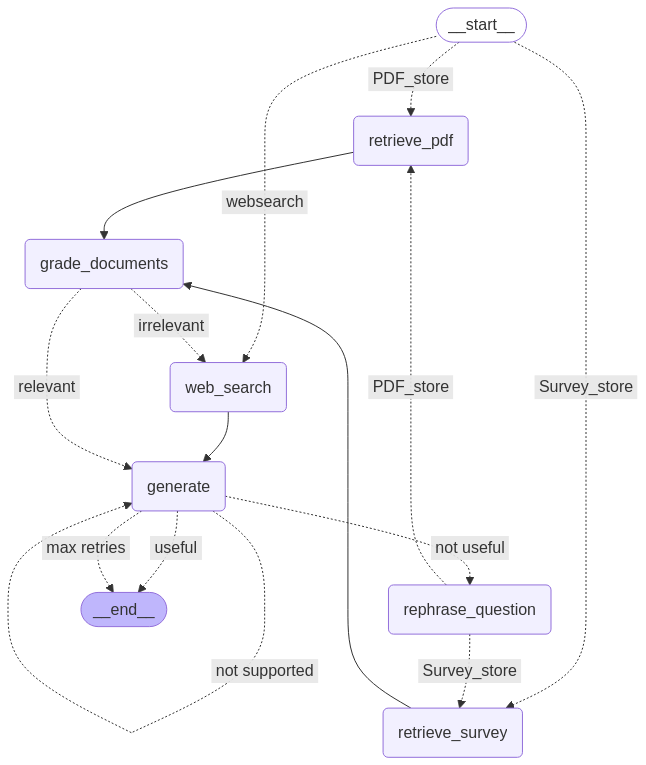

In [433]:
from IPython.display import Image, display

display(Image(graph1.get_graph().draw_mermaid_png()))

### Agentic RAG Test Cases

In [502]:
initial_state_1 = {"question" :"Who are the 12 director nominees that board recommends?"}
initial_state_2 = {"question" :"Can you summarize the full results of the sustainability survey?"}
initial_state_3 = {"question" :"What media types get attention when consumers look for brands at Christmas time such as Radio and others?"}

results = graph1.invoke(initial_state_1)

In [410]:
# results['messages']

## Business Analysis Agent

In [434]:
class State1(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    question :str
    generation : str 
    messages: Annotated[list[AnyMessage], operator.add]

In [511]:
# def web_search(state:State):

def get_insights(state:State1):
    print("---START ANALYSIS---")
    generation = state["generation"]
    

    insight_response = model.invoke(
            [SystemMessage(content=analysis_prompt)]
            + [HumanMessage(content=generation)]
        )
    return {"generation": insight_response.content}

#Edges functions:
def planning(state:State):
    print("---START PlANNING---")
    generation = state["generation"]
    # question = state["question"]

    planning_prompt_prompt_formated = planning_prompt.format(generation=generation)
    planning_response = model.invoke([HumanMessage(planning_prompt_prompt_formated)])
    return {"generation": [planning_response]}


In [436]:
graph_builder2 = StateGraph(State1)

In [437]:
graph_builder2.add_node("get_insights", get_insights)
graph_builder2.add_node("planning", planning)

In [438]:
graph_builder2.add_edge(START, "get_insights")
graph_builder2.add_edge("get_insights","planning")
graph_builder2.add_edge("planning",END)

In [504]:
graph2 = graph_builder2.compile()

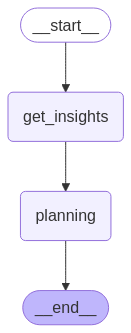

In [506]:
from IPython.display import Image, display

display(Image(graph2.get_graph().draw_mermaid_png()))

## Supervisor Agent Tools

In [440]:
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart"],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

class RAGAgent:
    def __init__(self):
        # Your RAGAgent with its own nodes/edges and vector store routing
        self.graph1 = graph_builder.compile()
    
    def run(self,question):
        # Logic to process the question and return an answer
        ans = self.graph1.invoke({"question": question})
        return ans
    
class BusAgent:
    def __init__(self):
        # Your RAGAgent with its own nodes/edges and vector store routing
        self.graph2 = graph_builder2.compile()
    
    def run(self,generation):
        # Logic to process the question and return an answer
        res = self.graph2.invoke({"generation": generation})
        return res

## Multi-Agent Graph

In [441]:
members = ["coder", "rag","business_analysis"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "\n\nRouting Rules:"
    "\n- If the request involves question about data, choose 'rag'."
    "\n- If the request involves coding, plotting, or data visualization, choose 'coder'."
    "\n- If the request involves business_analysis request and planning choose 'business_analysis'."
    
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal["coder", "rag","business_analysis","FINISH"]

# Define the State
class State(MessagesState):
    next: str

### Define MultiAgent Nodes

In [499]:
def supervisor_node(state: State) -> Command[Literal["coder", "rag","business_analysis", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = model.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(model, tools=[python_repl_tool])

def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )
# 
def rag_node(state: State) -> Command[Literal["supervisor"]]:
    rag_agent = RAGAgent()  # Instantiate the RAGAgent
    question = state["messages"]
    answer = rag_agent.run(question[0].content)  # Run the RAGAgent's graph
    return Command(
        update={
            "messages": [
                HumanMessage(content=answer["messages"][-1].content, name="rag") ]

        },
        goto="supervisor",
    )

def bus(state: State) -> Command[Literal["supervisor"]]:
    print(f'current state{state}')
    bus_agent = BusAgent()  # Instantiate the RAGAgent
    messages = state["messages"]
    answer = bus_agent.run(messages[-1].content)  # Run the RAGAgent's graph
    return Command(
        update={
            "messages": [
                HumanMessage(content=answer["generation"][-1].content, name="business_analysis") ]

        },
        goto="supervisor",
    )

In [500]:
# Build the supervisor graph
builder = StateGraph(State)
builder.set_entry_point("supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("rag", rag_node)
builder.add_node("coder", code_node)
builder.add_node("business_analysis", bus)

# graph= builder.compile()
graph = builder.compile(checkpointer=memory)
thread = {"configurable": {"thread_id": "2"}}

In [509]:
# from IPython.display import Image, display
# 
# display(Image(graph.get_graph().draw_mermaid_png()))

{'supervisor': {'next': 'rag'}}
----
We Retrieve Survey
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
start generation
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
start generation
---CHECK HALLUCINATIONS---
---DECISION: MAX RETRIES REACHED---
{'rag': {'messages': [HumanMessage(content='When looking for brands at Christmas time, the media types that get attention include:\n\n1. **TV** - 49%\n2. **Radio** - 30%\n3. **Print media** (e.g., newspapers, magazines, flyers) - 21%\n4. **Out of Home** (e.g., billboards, posters) - 22%\n\nThese media types are most likely to attract consumer attention during the holiday season.', additional_kwargs={}, response_metadata={}, name='rag', id='6abff129-3c2c-4e12-9fda-77415085ff4f')]}}
----
{'supervisor': {'next': 'coder'}}
----


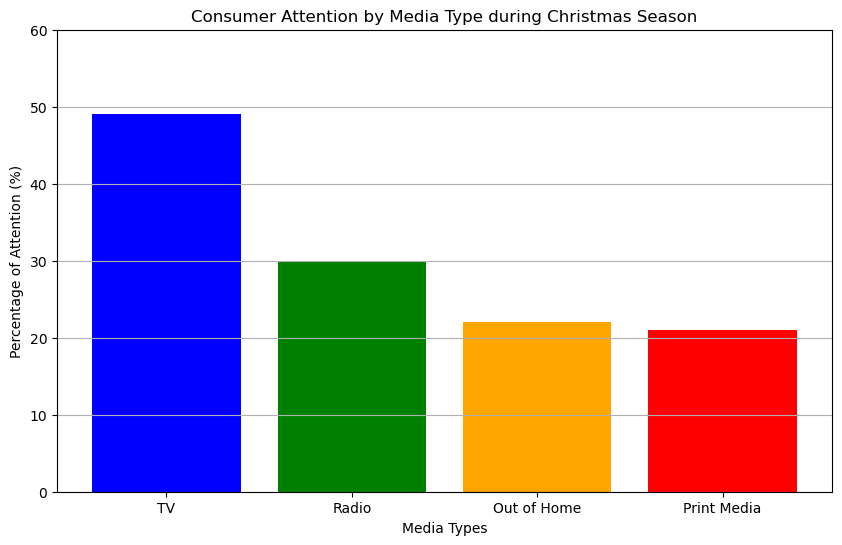

{'coder': {'messages': [HumanMessage(content="Here is a bar chart visualizing consumer attention by media type during the Christmas season:\n\n![Consumer Attention by Media Type during Christmas Season](attachment://chart.png)\n\n### Business Analysis\n\n1. **TV Dominance**: TV captures the highest percentage of consumer attention at 49%. This indicates that TV advertising is a crucial channel for brands during the holiday season. Businesses should invest heavily in compelling TV ads that resonate with the holiday spirit.\n\n2. **Radio's Role**: At 30%, radio remains a significant medium. It can effectively reach consumers who are on the go and may not be engaging with visual media. Utilizing radio ads can enhance brand reach, especially during commutes or while consumers are engaged in holiday shopping.\n\n3. **Out of Home Advertising**: With 22% attention, Out of Home advertising (such as billboards and posters) provides an additional visibility layer. This medium works well in urban

In [516]:
for s in graph.stream(
    {"messages": [("user","What media types get attention when consumers look for brands at Christmas time such as Radio and others ? \\n"
                    "Plot the results and visulite it in a good chart.\\n\\n" 
                   "\n Finally provide a business analysis and recommendation based on this answer ? ")]},thread
):
    print(s)
    print("----")
# results= graph.invoke(
#     {"messages": [("user","What media types get attention when consumers look for brands at Christmas time such as Radio and others ?"
#                     )]},thread
# )